In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [33]:
def torch_randnorm(size, dim=0):
    # Generate a random tensor
    rand_tensor = torch.rand(size)
    
    # Normalize along the specified dimension
    sum_along_dim = torch.sum(rand_tensor, dim=dim, keepdim=True)
    normalized_tensor = rand_tensor / sum_along_dim
    
    return normalized_tensor

# Example usage
normalized_tensor = torch_randnorm([5,6], dim=1)
print(normalized_tensor)
print(normalized_tensor.sum(dim=1))

tensor([[0.3187, 0.3106, 0.1491, 0.0018, 0.0614, 0.1584],
        [0.1877, 0.2229, 0.1241, 0.2582, 0.1937, 0.0134],
        [0.1285, 0.1561, 0.1183, 0.3250, 0.2481, 0.0239],
        [0.1893, 0.3484, 0.0801, 0.0271, 0.0796, 0.2755],
        [0.2603, 0.0185, 0.3653, 0.1012, 0.1398, 0.1148]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [34]:
class InteractionModule(nn.Module):
    def __init__(self, n_features):
        super(InteractionModule, self).__init__()
        self.n_features = n_features
        # Initialize a set of interaction tensors, one for the state tensor and one for each column of the transition tensor
        self.interaction_tensors = nn.ParameterList([nn.Parameter(torch_randnorm([n_features, n_features, n_features], dim = 0)) for _ in range(n_features + 1)])

    def forward(self, state_tensor, previous_transition_tensor):
        # Get batch size
        batch = state_tensor.shape[0]
        # Assuming previous_transition_tensors is a list of transition tensors from the previous step
        candidates = []
        for i in range(self.n_features + 1):
            if i == 0:  # Interaction with the state tensor
                current_tensor = state_tensor
            else:  # Interaction with columns of the previous transition tensor
                current_tensor = previous_transition_tensor[:, :, i - 1]

            interaction_tensor = self.interaction_tensors[i]
            current_tensor_expanded = current_tensor.unsqueeze(1).expand(-1, self.n_features, -1)  # Shape: [batch, n_features, n_features]
            interaction_tensor_expanded = interaction_tensor.unsqueeze(0).expand(batch, -1, -1, -1)  # Shape: [batch, n_features, n_features, n_features]
            # Multiply and sum over the last dimension to get the transition tensor
            candidate = torch.einsum('bik,bijk->bij', current_tensor_expanded, interaction_tensor_expanded)
            
            candidates.append(candidate)
            
        candidates_tensor = torch.stack(candidates, dim = -1)
        return candidates_tensor
    
    


In [35]:
class SelectorModule(nn.Module):
    def __init__(self, num_slices):
        super(SelectorModule, self).__init__()
        # A simple linear layer to compute importance scores for each slice
        self.importance = nn.Linear(num_slices, num_slices)

    def forward(self, x, temperature=0.5):
        # Assuming x is of shape [batch_size, height, width, num_slices]
        batch_size, _, _, num_slices = x.shape

        # Compute importance scores by reducing x across spatial dimensions
        # Here, we take the mean of x across the spatial dimensions to get a vector per slice
        x_reduced = x.mean(dim=[1, 2])  # Shape: [batch_size, num_slices]

        # Compute scores for each slice
        scores = self.importance(x_reduced)  # Shape: [batch_size, num_slices]
        
        # Apply Gumbel-Softmax to approximate a discrete selection of slices
        weights = F.gumbel_softmax(scores, tau=temperature, hard=False, dim=-1)
        #weights = torch.softmax(scores,dim=-1)
        #print(weights)
        # Correct application of weights:
        # We need to ensure weights are applied across the num_slices dimension correctly.
        # Since weights are [batch_size, num_slices] and x is [batch_size, height, width, num_slices],
        # we permute x to bring num_slices to the front for broadcasting.
        x_permuted = x.permute(0, 3, 1, 2)  # Shape: [batch_size, num_slices, height, width]
        
        # Now, multiply by weights. We need to reshape weights to [batch_size, num_slices, 1, 1] for broadcasting.
        weighted_slices = x_permuted * weights.view(batch_size, num_slices, 1, 1)
        
        # Finally, sum the weighted slices across the num_slices dimension (now the first dimension after permute)
        selected = weighted_slices.sum(dim=1)  # Shape: [batch_size, height, width]\
            
        #selected = x[:, :, :, 0]

        return selected

# Example usage
batch_size = 10
tensor = torch.rand(batch_size, 5, 5, 6)  # Example tensor
model = SelectorModule(num_slices=6)

result = model(tensor)
print(result.shape)  # Should print torch.Size([10, 5, 5])

torch.Size([10, 5, 5])


In [36]:
class NeuralCoilLayer(nn.Module):
    def __init__(self, n_features):
        super(NeuralCoilLayer, self).__init__()
        self.n_features = n_features
        self.interaction_module = InteractionModule(n_features)
        self.selector_module = SelectorModule(n_features + 1)
        
    def step_coil(self, state_tensor, previous_transition_tensor):
        # Generate candidates
        candidates = self.interaction_module(state_tensor, previous_transition_tensor)
        # Select one candidate
        selected_transition_tensor = self.selector_module(candidates)
        
        new_state_tensor = torch.matmul(selected_transition_tensor, state_tensor.unsqueeze(-1)).squeeze(-1)
        
        softmax_tensor = torch.softmax(new_state_tensor, dim = 1)
        
        return softmax_tensor, selected_transition_tensor


    def forward(self, x):
        batch, length, n_features = x.size()
        output = x.new_empty(batch, length, n_features)

        # Initialize previous transition tensors (for the first step)
        # Assuming it's a list of zero tensors for simplicity
        transition_tensor = torch.zeros(batch, n_features, n_features)

        for l in range(length):
            state_tensor = x[:, l, :]
            
            # Compute output for this step
            output[:, l, :], transition_tensor = self.step_coil(state_tensor, transition_tensor)

        return output, transition_tensor


# Sequence-to-Sequence Check

In [37]:
n_features = 16
batch, length, dim = 13, 64, n_features
x = torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features
)
y = model(x)

print(y[0].shape)
assert y[0].shape == x.shape

torch.Size([13, 64, 16])


## Consistency Check

In [38]:
n_features = 4
batch, length, dim = 13, 64, n_features
x =torch_randnorm([batch, length, dim], dim = 2)
model = NeuralCoilLayer(
    n_features = n_features
)

l = 1
state_tensor = x[:, l, :]
print(state_tensor[1,:])
transition_tensor = torch_randnorm([batch, n_features, n_features], dim = 1)
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])

tensor([0.2548, 0.2243, 0.0219, 0.4990])
tensor([0.2540, 0.2363, 0.2599, 0.2498], grad_fn=<SliceBackward0>)
tensor([0.2555, 0.2336, 0.2588, 0.2522], grad_fn=<SliceBackward0>)


This should be the same as if we just look at the batches independently

In [39]:
batch = 2
transition_tensor = torch_randnorm([batch, n_features, n_features], dim = 2)
l = 1
state_tensor = x[0:2, l, :]
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
new_state[1,:]

tensor([0.2320, 0.2715, 0.2344, 0.2621], grad_fn=<SliceBackward0>)

In [40]:
states = []
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor)

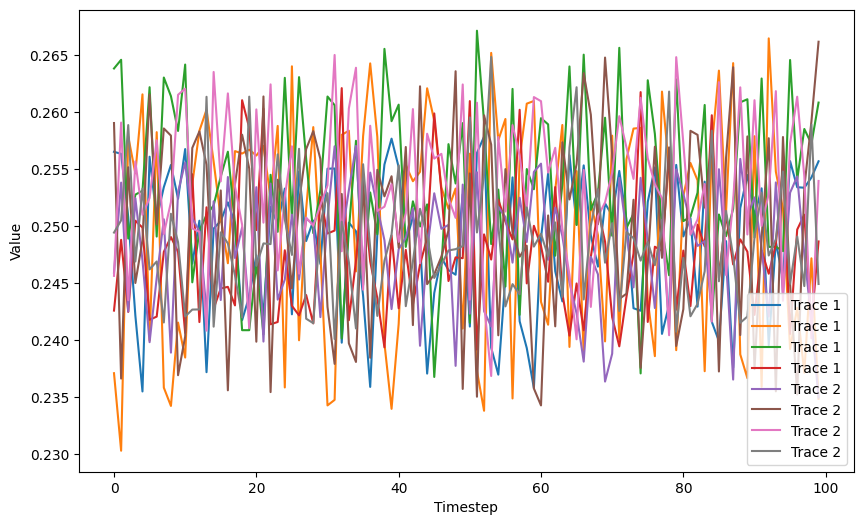

In [41]:
import matplotlib.pyplot as plt

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

# Example Training

## Simple Data Generation

In [42]:
import numpy as np
import torch

def generate_normalized_multivariate_time_series(n_features, total_length, amplitude=1.0):
    t = np.linspace(0, 100 * np.pi, total_length)
    series = np.zeros((total_length, n_features))
    for i in range(n_features):
        series[:, i] = amplitude * np.cos(t * (i + 1) / n_features) + 10
    
    # Normalize such that each timestep's values sum to 1
    series_sum = np.sum(series, axis=1, keepdims=True)
    series_normalized = series / series_sum
    
    return series_normalized

def segment_time_series(series, length):
    # Assuming series is a numpy array of shape [total_length, n_features]
    total_length, n_features = series.shape
    segments = []
    for start in range(0, total_length - length, length):
        segment = series[start:start + length]
        segments.append(segment)
    return np.stack(segments)


In [43]:
n_features = 4
length = 64  # Segment length
total_length = 1024  # Arbitrary total length for the generated series

# Generate and segment the time series
series = generate_normalized_multivariate_time_series(n_features, total_length)
series_x = series[:-1,]
series_y = series[1:,]

segments_x = segment_time_series(series_x, length)
segments_y = segment_time_series(series_y, length)

# Convert to tensors
segments_tensor_x = torch.tensor(segments_x, dtype=torch.float)
segments_tensor_y = torch.tensor(segments_y, dtype=torch.float)

# Prepare inputs and targets
X = segments_tensor_x
# Shift segments to the right by one timestep to create the targets
Y =  segments_tensor_y


In [44]:
from torch import nn, optim

# Model
model = NeuralCoilLayer(
    n_features = n_features
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs, transition_tensor = model(X)
    loss = criterion(outputs, Y)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')


Epoch [10/500], Loss: 0.000239952772972174
Epoch [20/500], Loss: 0.00023402037913911045
Epoch [30/500], Loss: 0.00022449649986810982
Epoch [40/500], Loss: 0.00019276540842838585
Epoch [50/500], Loss: 0.0001130851887864992
Epoch [60/500], Loss: 8.290013647638261e-05
Epoch [70/500], Loss: 7.828861271264032e-05
Epoch [80/500], Loss: 5.875412534805946e-05
Epoch [90/500], Loss: 5.211356983636506e-05
Epoch [100/500], Loss: 5.3825384384253994e-05
Epoch [110/500], Loss: 4.396382792037912e-05
Epoch [120/500], Loss: 4.496262044995092e-05
Epoch [130/500], Loss: 4.986342173651792e-05
Epoch [140/500], Loss: 3.789390393649228e-05
Epoch [150/500], Loss: 3.1670573662268e-05
Epoch [160/500], Loss: 3.617394031607546e-05
Epoch [170/500], Loss: 3.707380892592482e-05
Epoch [180/500], Loss: 3.298709634691477e-05
Epoch [190/500], Loss: 3.128659591311589e-05
Epoch [200/500], Loss: 2.8178996217320673e-05
Epoch [210/500], Loss: 2.9133921998436563e-05
Epoch [220/500], Loss: 2.746452810242772e-05
Epoch [230/500],

In [45]:
import plotly.graph_objects as go

def plot_model_output_vs_target(model_outputs, targets, batch_index=0, feature_index=0):
    # Extract the specified feature for the given batch from both the model outputs and targets
    model_output_series = model_outputs[batch_index, :, feature_index].detach().numpy()
    target_series = targets[batch_index, :, feature_index].numpy()
    
    # Create a range for the x-axis (timesteps)
    timesteps = list(range(model_output_series.shape[0]))
    
    # Create traces
    model_trace = go.Scatter(x=timesteps, y=model_output_series, mode='lines', name='Model Output')
    target_trace = go.Scatter(x=timesteps, y=target_series, mode='lines', name='Target')
    
    # Create the figure and add traces
    fig = go.Figure()
    fig.add_trace(model_trace)
    fig.add_trace(target_trace)
    
    # Add title and labels
    fig.update_layout(title=f'Model Output vs Target for Feature {feature_index}, Batch {batch_index}',
                      xaxis_title='Timestep',
                      yaxis_title='Value')
    
    # Show the figure
    fig.show()

# Assuming `y` and `Y` are your model outputs and targets, respectively
# Adjust batch_index and feature_index as needed
plot_model_output_vs_target(outputs, Y, batch_index=1, feature_index=3)


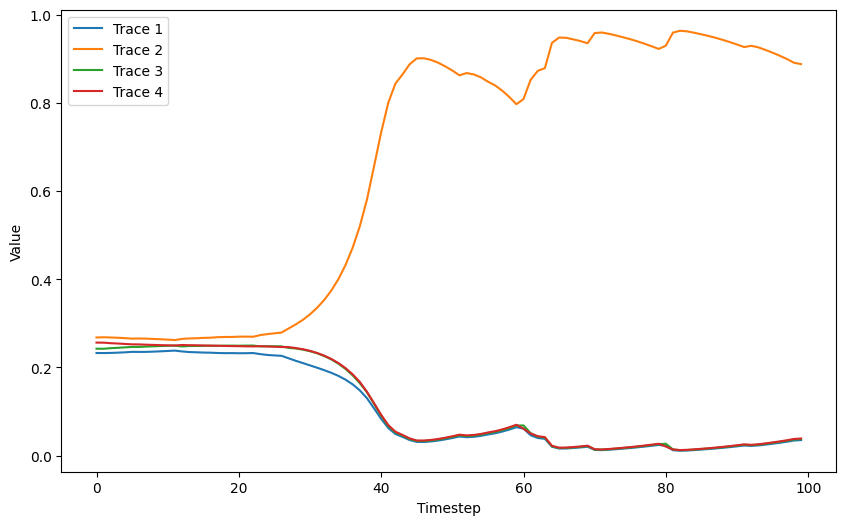

In [46]:
states = []
batch = 1
state_tensor = outputs[:,length-1,:]
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor[batch,:])
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()